In [1]:
#import necessary packages
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models, fitting
import os
import pickle
from tqdm import tqdm

# check photometric redshift reliability

## zCOSMOS catalog

In [2]:
#read spectroscopic redshift catalog
zcosmos = Table.read('./datas/zCOSMOS_crossmatched.fits')
zcosmos = zcosmos.to_pandas()

#catalog which has positive redshift
zcosmos = zcosmos[(zcosmos['zphot'] > 0) & (zcosmos['zphot'] < 9) & (zcosmos['z'] > 0)]
zcosmos = zcosmos.dropna(subset = ['z'], axis = 0)

#load updated data!!

In [3]:
zcosmos.keys()

Index(['recno', 'zCOSMOS', 'RAJ2000_1', 'DEJ2000_1', 'z', 'CC', 'Imag',
       'RAJ2000_2', 'DEJ2000_2', 'Seq', 'OType', 'zphot', 'Cl', 'Age', 'Mass',
       'SFR', 'sSFR', 'Separation'],
      dtype='object')

(array([1.386e+03, 2.735e+03, 2.740e+03, 4.830e+02, 5.400e+01, 5.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([2.70000e-03, 3.21340e-01, 6.39980e-01, 9.58620e-01, 1.27726e+00,
        1.59590e+00, 1.91454e+00, 2.23318e+00, 2.55182e+00, 2.87046e+00,
        3.18910e+00]),
 <BarContainer object of 10 artists>)

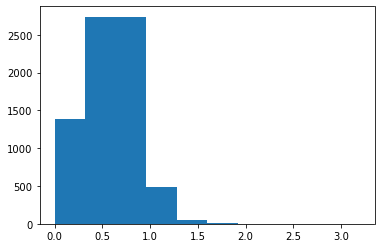

In [4]:
mask = zcosmos['z'] > 0
plt.hist(zcosmos[mask]['z'])

In [5]:
#model for gaussian fitting
from astropy.modeling import models, fitting

fitter = fitting.LevMarLSQFitter()
model = models.Gaussian1D()

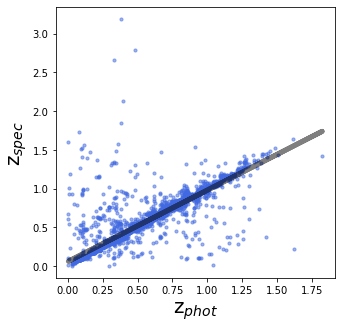

In [6]:
#check photometric redshift reliability

photz = zcosmos['zphot']
specz = zcosmos['z']

diff = np.abs(photz - specz) / (1 + specz)
med_diff = np.median(diff)
std_diff = np.std(diff)

lin_fit = fitting.LinearLSQFitter()
line_init = models.Linear1D()

indexs = photz[photz.values < 2].index
fitted_line = lin_fit(line_init, photz[indexs], specz[indexs])

plt.figure(figsize = (5,5))
plt.scatter(photz[indexs], specz[indexs], s = 10, color = 'royalblue', alpha = .5)
plt.plot(photz[indexs], fitted_line(photz[indexs]), color = 'black', alpha = .5, lw = 5)
plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel('z$_{spec}$', fontsize = 20)

plt.savefig('zphot_scatter.png', bbox_inches = 'tight')

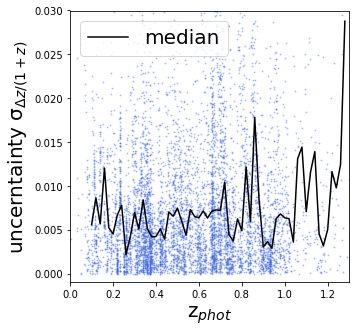

In [7]:
meds = []
stds = []

phots = []
diffs = []

for i in np.arange(0.0, 1.3, 0.02):
    sample = zcosmos[(zcosmos['zphot'] >= i) & (zcosmos['zphot'] < i + 0.02)]
    
    photz = sample['zphot']
    specz = sample['z']
    
    diff = np.abs(photz - specz) / (1 + specz)
    med_diff = np.nanmedian(diff)
    std_diff = np.std(diff)
    
    phots.extend(photz.tolist())
    diffs.extend(diff.tolist())
    
    meds.append(med_diff)
    stds.append(std_diff)

one_sigma = [x + y for x, y in zip(meds, stds)]

plt.figure(figsize = (5,5))
plt.plot(np.arange(0.1, 1.3, 0.02), meds[4:-1],  color = 'black', label = 'median')
# plt.fill_between(np.arange(0.1, 1.32, 0.02), meds[5:-15], one_sigma[5:-15], color = 'grey', alpha = .25)
plt.scatter(phots, diffs, s = 1, color = 'royalblue', alpha = .3)

plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel('uncerntainty σ$_{Δz/(1+z)}$', fontsize = 20)
plt.ylim(-0.001, 0.03)
plt.xlim(0, 1.3)

plt.legend(fontsize = 20)
plt.savefig('zphot_accuracy.png', bbox_inches = 'tight')

[22, 34, 32, 37, 17, 11, 15, 1, 13, 14, 8, 8]

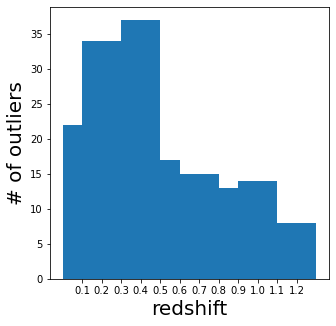

In [8]:
outliers = []

for i in np.arange(0.0, 1.2, 0.1):
    sample = zcosmos[(zcosmos['zphot'] >= i) & (zcosmos['zphot'] < i + 0.1)]
    
    photz = sample['zphot']
    specz = sample['z']
    
    diff = np.abs(photz - specz) / (1 + specz)
    out = diff  > 0.15
#     print(diff)
    length = len(diff[out])
    #print(length)
    outliers.append(length)

plt.figure(figsize = (5,5))
plt.bar(np.arange(0.1, 1.3, 0.1), outliers, width = 0.2)
plt.xticks(np.arange(0.1, 1.3, 0.1))
plt.ylabel('# of outliers', fontsize = 20)
plt.xlabel('redshift', fontsize = 20)
# plt.savefig('outliers.png', bbox_inches = 'tight')

outliers

## Hasinger catalog


In [33]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')
#mass complete sample
total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

In [29]:
hasinger = Table.read('./datas/Hasinger_10k_spec_z')
# hasinger = hasinger.to_pandas()
hasinger.keys()

['recno',
 'ID',
 'RAJ2000',
 'DEJ2000',
 'sel',
 'imag',
 'Kmag',
 'zspec',
 'Qf',
 'Q',
 'Remarks',
 'CCat',
 'SimbadName']

In [70]:
hasinger_c = Table.read('./datas/Hasinger_crossmatch')

In [72]:
hasinger_c.keys()

['RAJ2000_1',
 'DEJ2000_1',
 'Seq',
 'OType',
 'zphot',
 'Cl',
 'Age',
 'Mass',
 'SFR',
 'sSFR',
 'recno',
 'ID',
 'RAJ2000_2',
 'DEJ2000_2',
 'sel',
 'imag',
 'Kmag',
 'zspec',
 'Qf',
 'Q',
 'Remarks',
 'CCat',
 'SimbadName',
 'Separation']

In [91]:
hmask = (hasinger_c['zphot'] > 0) & (hasinger_c['zphot'] < 1) & (hasinger_c['zspec'] > 0) & (hasinger_c['zspec'] < 1)
hasinger_c = hasinger_c[hmask]

Text(0, 0.5, 'spec-z')

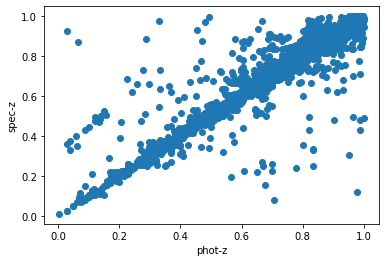

In [94]:
plt.scatter(hasinger_c['zphot'], hasinger_c['zspec'])
plt.xlabel('phot-z')
plt.ylabel('spec-z')

In [93]:
# hasinger_c

In [69]:
# z2

# find mass complete sample

In [10]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')
total = total.to_pandas()
#mass complete sample
total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

In [11]:
#crossmatched with catalog2016 & zcosmos data
total_z2 = Table.read('./datas/cosmos2015.fits')
total_z2 = total_z2[(total_z2['zphot'] > 0) & (total_z2['zphot'] < 2) & (total_z2['OType'] == 0) & (total_z2['Kswmag'] < 50)]
total_z2 = total_z2.to_pandas()

len(total_z2) # 331k for having Ks mag

331029

In [12]:
total_z2.keys()

Index(['RAJ2000', 'DEJ2000', 'Seq', 'Area', 'Sat', 'Cfl', 'Deep', 'Flag',
       'Ksmag', 'e_Ksmag', 'Ymag', 'e_Ymag', 'Hmag', 'e_Hmag', 'Jmag',
       'e_Jmag', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'ipmag', 'e_ipmag',
       'rmag', 'e_rmag', 'umag', 'e_umag', 'zpmag', 'e_zpmag', 'zppmag',
       'e_zppmag', '_3.6mag', 'e_3.6mag', '_4.5mag', 'e_4.5mag', '_5.8mag',
       'e_5.8mag', '_8.0mag', 'e_8.0mag', 'Hwmag', 'e_Hwmag', 'Kswmag',
       'e_Kswmag', 'yHmag', 'e_yHmag', '_24mag', 'e_24mag', 'ID24um', 'ID2006',
       'ID2008', 'ID2013', 'NUVmag', 'e_NUVmag', 'FUVmag', 'e_FUVmag', 'zphot',
       'OType', 'Age', 'Mass', 'SFR', 'Lnuv', 'Lr', 'Lk'],
      dtype='object')

In [13]:
phots = []
masses = []
q_masses = []

for i in np.arange(0.0, 1.25, 0.05):
    #len = 1030, dataframe
    sample = total_z2[(total_z2['OType'] == 0) & (total_z2['zphot'] >= i) & (total_z2['zphot'] < i + 0.1)]

    sample_seq = sample['Seq']

    q_mask = total['Seq'].isin(sample_seq)
    q_sample = total[q_mask]
    
    #only for quiescent 
    q_sample = q_sample[q_sample['Cl'] == 0]
    # q_sample['Seq']
    #quiesent Seq mask
    mask2 = sample['Seq'].isin(q_sample['Seq'])
    q_sample_k = sample[mask2]
    q_sample_k
    
    photz = sample['zphot']
    
    #calculate limiting mass
    m_limit = sample['Mass'] + 0.4 * (sample['Kswmag'] - 24)
    q_mass = q_sample['Mass'].values+ 0.4 * (q_sample_k['Kswmag'].values - 24)
    
    m_limit = m_limit.sort_values()
    m_index = int(len(m_limit) * 0.9)
    critical_mass = m_limit.iloc[m_index]
    
    q_mass = pd.Series(q_mass)
    q_mass = q_mass.sort_values()
    qm_index= int(len(q_mass) * 0.9)
    qcritical_mass = q_mass.iloc[qm_index]
    
    med_phots = np.median(photz)
    
    phots.append(med_phots)
    masses.append(critical_mass)
    q_masses.append(qcritical_mass)


9.546119880676269

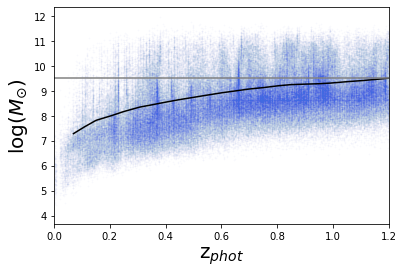

In [14]:
plt.scatter(total_z2['zphot'], total_z2['Mass'], s = 1, alpha = .02, color = 'royalblue')
# phots
plt.plot(phots, masses, color = 'black')
# plt.plot(phots, q_masses, color = 'red')
plt.xlim(0, 1.2)

plt.axhline(y = max(masses), color = 'grey')
plt.xlabel('z$_{phot}$', fontsize = 20)
plt.ylabel(r'log($M_{\odot}$)', fontsize = 20)
# plt.ylim(4, 12)

plt.savefig('mass_complete.png', bbox_inches = 'tight')
max(masses) #max mass = 9.54576 ~ 9.6

In [ ]:
# following Lee et al.

In [32]:
sample = total[(total['zphot'] <= 1.2) &  (total['zphot'] > 0)]

In [33]:
np.max(sample['zphot'])

1.2

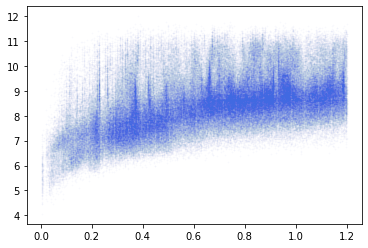

In [34]:
plt.scatter(sample['zphot'], sample['Mass'], s = 1, alpha = .02, color = 'royalblue')

In [39]:
temp = total[(total['zphot'] > 1.18) & (total['zphot'] < 1.22)]

In [40]:
np.percentile(temp['Mass'], 75)

9.73

(array([ 17.,  88., 388., 760., 959., 788., 486., 352., 246.,  40.]),
 array([ 6.74 ,  7.227,  7.714,  8.201,  8.688,  9.175,  9.662, 10.149,
        10.636, 11.123, 11.61 ]),
 <BarContainer object of 10 artists>)

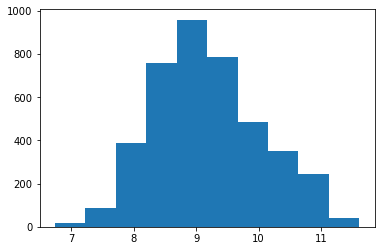

In [37]:
plt.hist(temp['Mass'])

# Extra Figures

# gaussian number density

In [7]:
from astropy.modeling import models

In [29]:
mu = 3
std = 1
g = models.Gaussian1D(amplitude = 1, mean = mu, stddev = std)

In [70]:
x = np.linspace(1, 8)
y = g(x)

xp = np.linspace(mu + 1 * std, 10)
yp = g(xp)

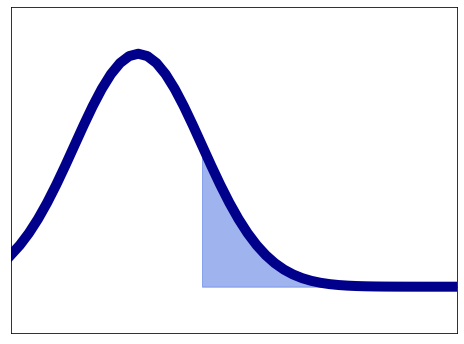

In [76]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot()
ax.plot(x, y, lw = 10, color = 'darkblue')
ax.fill_between(xp, yp, color = 'royalblue', alpha = .5)
# ax.axvline(mu + 1 * std, lw = 10, color = 'orange')

ax.set_ylim(-0.2, 1.2)
ax.set_xlim(1, 8)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig('sigma.png')
# ax.annotate()
# plt.grid(True)